# Imports and helper variables

In [1]:
import phoebe
from phoebe import u

from astropy.table import Table, vstack
from astropy.time import Time

import utils as gen_utils
from optimizers import opt_utils, dc_optimizer

import importlib
importlib.reload(gen_utils)
importlib.reload(opt_utils)
importlib.reload(dc_optimizer)

logger = phoebe.logger(clevel='WARNING')

CLEAN_ITURBIDE_PATH = "/home/ramon/uanl/thesis/Backup Data/Iturbide/cleaned-iturbide.ecsv"
CLEAN_ZTF_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/cleaned-ztf-flux.ecsv"

ORBITAL_PERIOD = 0.3335614 *u.day # from periodogram notebook

In [2]:
ztfDatasetsPassbands = {
    'lcZtfR': 'ZTF:r',
    'lcZtfG': 'ZTF:g'
}

ztfDatasets = ['lcZtfR', 'lcZtfG']
iturbideDataset = 'lcIturbide'
allDatasets = ztfDatasets + [iturbideDataset]

# Load data

In [3]:
ztfData = Table.read(CLEAN_ZTF_PATH)
ztfData

time,hjd,mag,err,filter,norm_flux,norm_ferr
,,mag,mag,,,mag
TimeDelta,Time,float64,float64,str5,float64,float64
-0.16647319774995495,2459153.6732318965,17.3823967,0.0181920044,ZTF:g,1.2380634996516526,0.02074431757404617
-0.1634516990197526,2459402.84662591,17.3224964,0.0177861098,ZTF:g,1.3082870422375963,0.021431851384507213
-0.16307953599682157,2458763.74333845,17.3525009,0.0179866366,ZTF:g,1.2726273136302413,0.021082731622273445
-0.1630665944627809,2459855.823404422,17.4029655,0.0183366165,ZTF:g,1.2148296973382426,0.02051683104540558
-0.162641181344041,2458761.7424083506,17.3411255,0.0179099627,ZTF:g,1.2860308890792689,0.021213960770138054
-0.16087291026641393,2458760.7434923947,17.3354874,0.0178722534,ZTF:g,1.2927264653639197,0.021279510496766733
-0.1601519323589094,2458790.7647401816,17.3063049,0.0176801793,ZTF:g,1.3279436299471448,0.021624296375921854
-0.16007052019805004,2458762.7456632387,17.3841858,0.0182044767,ZTF:g,1.2360250713293053,0.020724361509748844


In [4]:
iturbideData = Table.read(CLEAN_ITURBIDE_PATH)
iturbideData

time,hjd,mag,err,filter,obsv_date,norm_flux,norm_ferr
,,mag,mag,,,,mag
TimeDelta,Time,float64,float64,str18,str10,float64,float64
-0.16639715815976874,2459924.53372411,1.2622999999999998,0.027856776554368235,Iturbide:Luminance,2022-12-11,1.1607000415833948,0.029780126667358835
-0.16529486084112877,2459880.83828183,1.2027999999999999,0.0206155281280883,Iturbide:Luminance,2022-10-28,1.2260833646033908,0.023280384295551036
-0.16459222079941982,2459880.83898447,1.2391000000000005,0.0206155281280883,Iturbide:Luminance,2022-10-28,1.1857687481671586,0.02251490635949991
-0.16389329068118685,2459880.8396834,1.2197999999999993,0.0206155281280883,Iturbide:Luminance,2022-10-28,1.2070353797212003,0.02291870871873846
-0.1631944704590177,2459880.84038222,1.251100000000001,0.022472205054244233,Iturbide:Luminance,2022-10-28,1.1727353057793763,0.02427288336737085
-0.16264299432416546,2459922.53610982,1.3013000000000012,0.03956008088970497,Iturbide:Luminance,2022-12-09,1.1197472383220946,0.04079931306510494
-0.16249565070250982,2459880.84108104,1.1916999999999973,0.0206155281280883,Iturbide:Luminance,2022-10-28,1.2386824944024528,0.023519611571590764
-0.16179683048034066,2459880.84177986,1.191200000000002,0.0206155281280883,Iturbide:Luminance,2022-10-28,1.2392530601392926,0.02353044524734478


# Model setup

In [12]:
b = phoebe.default_contact_binary()
b.add_dataset('mesh', dataset='mesh01', compute_phases=phoebe.linspace(0, 1, 20), columns=['teffs'])

b.set_value(qualifier='period', component='binary', value=ORBITAL_PERIOD)

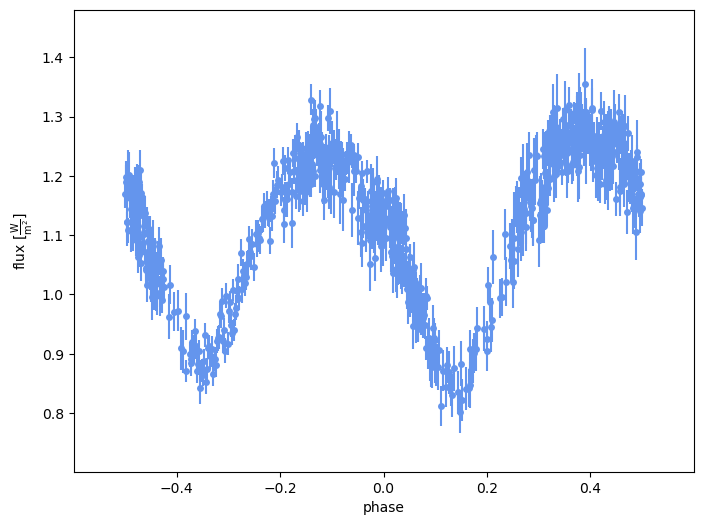

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [13]:
# loading Iturbide data; Luminance filter seems to be very similar to Gaia:BP
b.add_dataset('lc', times=iturbideData['hjd'].value, fluxes=iturbideData['norm_flux'], sigmas=iturbideData['norm_ferr'].data, dataset=iturbideDataset, passband='Gaia:BP', pblum_mode='dataset-scaled', overwrite=True)
b.plot(dataset=iturbideDataset, x='phase', show=True, c=gen_utils.ITURBIDE_PLOT_COLORS, s=0.008)

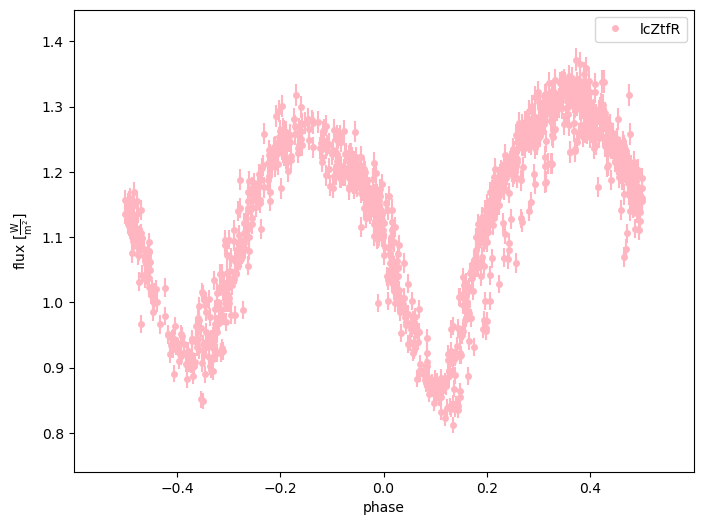

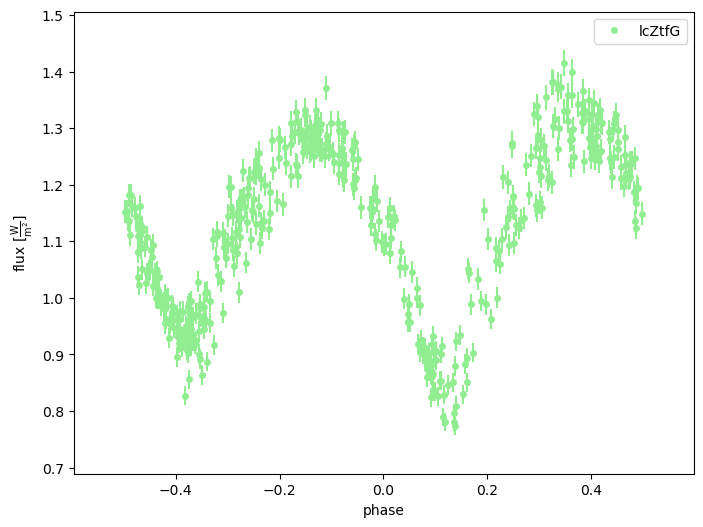

In [14]:
# ztf data
for d, band in ztfDatasetsPassbands.items():
    bandData = ztfData[ztfData['filter'] == band]
    b.add_dataset('lc', times=bandData['hjd'].value, fluxes=bandData['norm_flux'], sigmas=bandData['norm_ferr'].data, dataset=d, passband=band, pblum_mode='dataset-scaled', overwrite=True)
    b.plot(x='phase', show=True, dataset=d, s=0.008, c=gen_utils.ZTF_PLOT_COLORS, legend=True)

# EBAI estimator

In [15]:
b.add_solver('estimator.ebai', ebai_method='knn', solver='ebai_all', phase_bin=False, overwrite=True)
b.run_solver('ebai_all', solution='ebai_all_solution', overwrite=True)
gen_utils.printFittedVals(b, 'ebai_all_solution')
print("=========================")
gen_utils.printFittedTwigsConstraints(b, 'ebai_all_solution')

/home/ramon/anaconda3/envs/mapta-tesis/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.0.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ramon/anaconda3/envs/mapta-tesis/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


t0_supconj@binary@orbit@component 0.04573 d 
teffratio@binary@orbit@component 0.97830  
incl@binary@orbit@component 1.39686 rad 
fillout_factor@contact_envelope@envelope@component 0.29557  
q@binary@orbit@component 3.49364  
  t0_supconj@binary@orbit@component 0.00000 d 
C teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
C fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


In [16]:
b.flip_constraint('pot', solve_for='requiv@primary')
b.flip_constraint('fillout_factor', solve_for='pot')
b.flip_constraint('teffratio', solve_for='teff@secondary')

<ConstraintParameter: {teff@secondary@component} = {teffratio@binary@component} * {teff@primary@component} (solar units) => 6000.0 K>

Adopted:
t0_supconj@binary@orbit@component 0.04573 d 
teffratio@binary@orbit@component 0.97830  
incl@binary@orbit@component 1.39686 rad 
fillout_factor@contact_envelope@envelope@component 0.29557  
q@binary@orbit@component 3.49364  

Original values:
  t0_supconj@binary@orbit@component 0.00000 d 
  teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
  fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


100%|██████████| 2429/2429 [01:46<00:00, 22.80it/s]


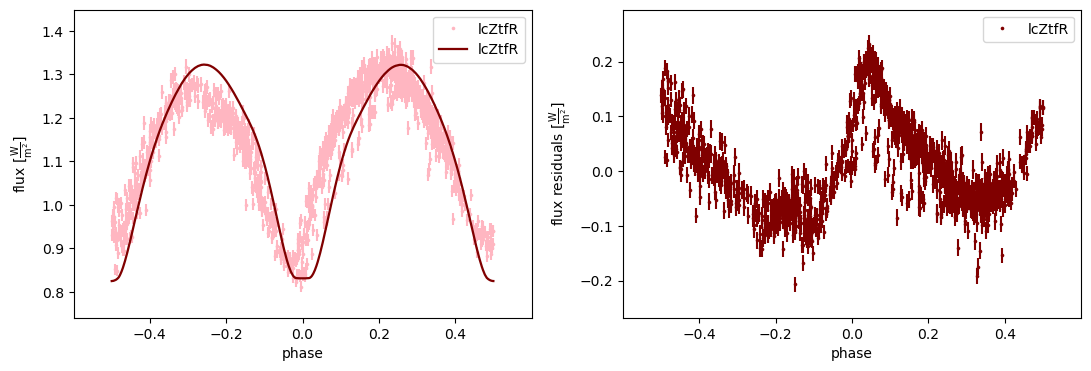

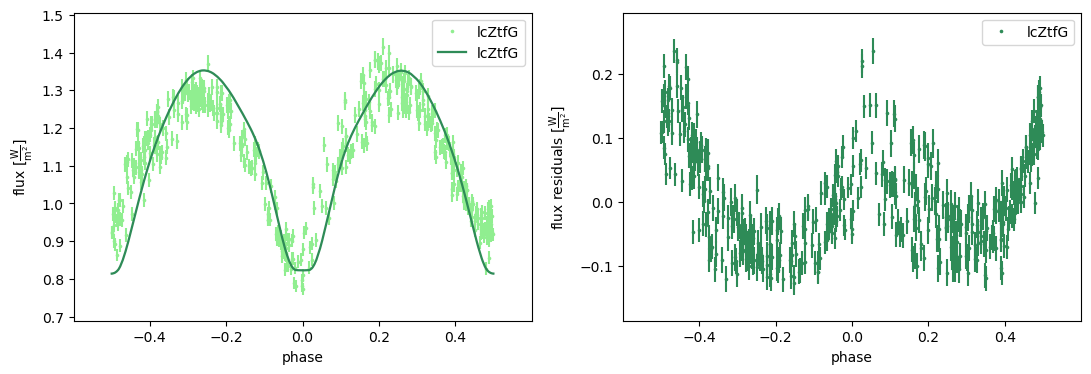

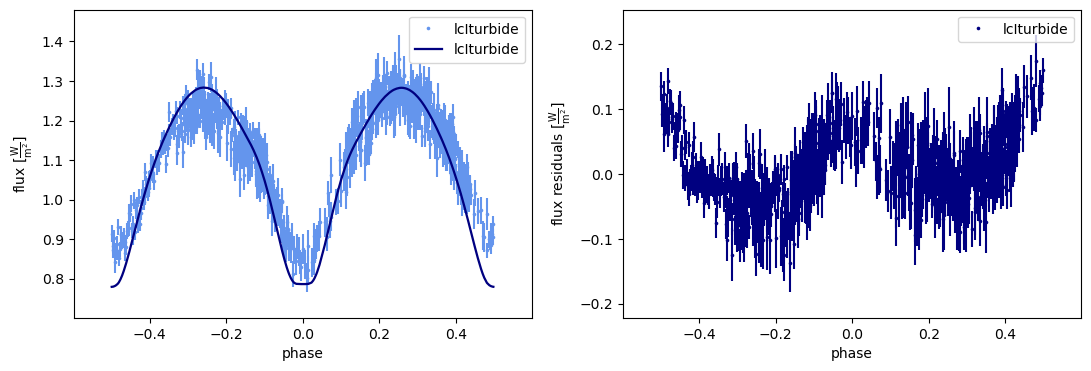

{'l-c-Z-t-f-R': <Figure size 1300x400 with 2 Axes>,
 'l-c-Z-t-f-G': <Figure size 1300x400 with 2 Axes>,
 'l-c-I-t-u-r-b-i-d-e': <Figure size 1300x400 with 2 Axes>}

In [17]:
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_name='ebai_all_solution')
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 4), datasetGroups=allDatasets, model=computeModelName)

# Compute phase adjustment

Reduce forward model compute time.